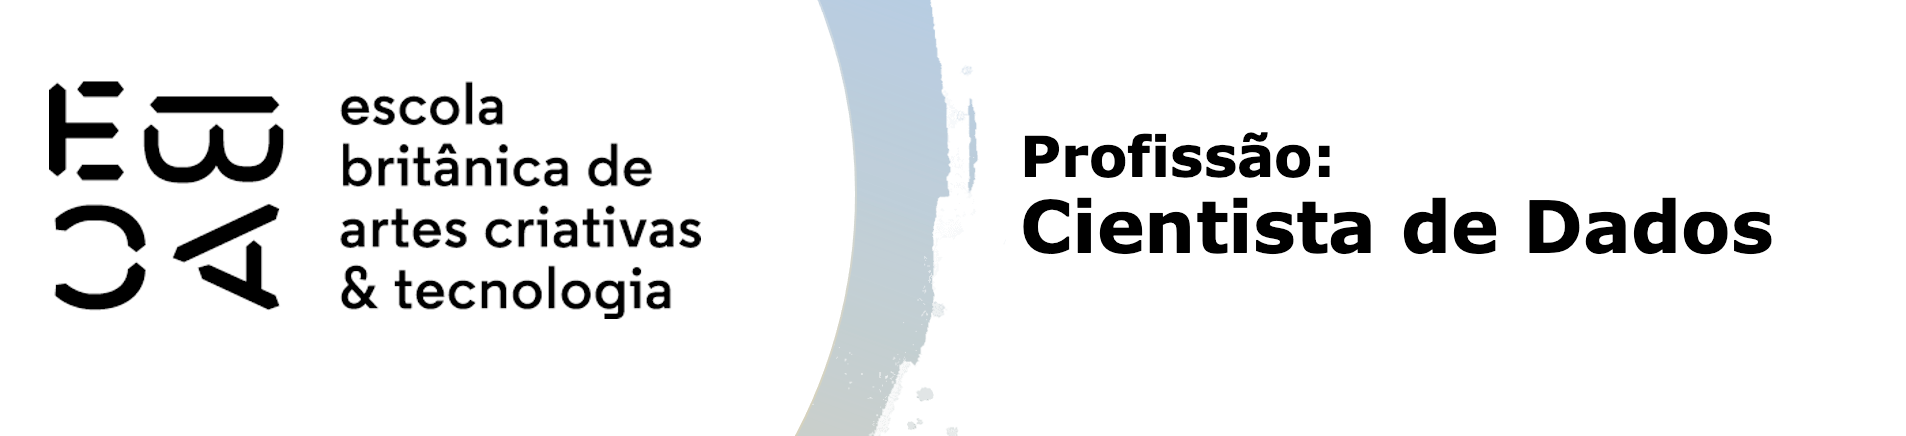

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [28]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report

import statsmodels.api as sm

from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, finalize_model, save_model

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

oot_months = df['data_ref'].sort_values().unique()[-3:]
df_oot = df[df['data_ref'].isin(oot_months)].copy()
df_dev = df[~df['data_ref'].isin(oot_months)].copy()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
df_dev['data_ref'].dt.date.value_counts().sort_index()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
Name: count, dtype: int64

In [6]:
qualitativas = ['sexo', 'posse_de_veiculo', 'educacao', 'estado_civil', 'tipo_residencia']
quantitativas = ['idade', 'tempo_emprego', 'renda', 'qt_pessoas_residencia']

print("\nDescritiva Qualitativa:")
for var in qualitativas:
    print(f"\n{var}:")
    print(df_dev[var].value_counts(dropna=False, normalize=True).to_string())


Descritiva Qualitativa:

sexo:
sexo
F    0.673008
M    0.326992

posse_de_veiculo:
posse_de_veiculo
N    0.610488
S    0.389512

educacao:
educacao
Médio                  0.675748
Superior completo      0.272400
Superior incompleto    0.039265
Fundamental            0.011502
Pós graduação          0.001085

estado_civil:
estado_civil
Casado      0.701915
Solteiro    0.122035
União       0.076847
Separado    0.056980
Viúvo       0.042223

tipo_residencia:
tipo_residencia
Casa             0.898893
Com os pais      0.044550
Governamental    0.031237
Aluguel          0.013770
Estúdio          0.007160
Comunitário      0.004390


In [7]:
print("\nDescritiva Quantitativa:")
df_dev[quantitativas].describe().round(2)


Descritiva Quantitativa:


,idade,tempo_emprego,renda,qt_pessoas_residencia
count,600000.00,499125.00,600000.00,600000.00
mean,43.80,7.75,27222.84,2.21
std,11.23,6.69,87377.88,0.90
min,22.00,0.12,161.86,1.00
25%,34.00,3.05,4670.60,2.00
50%,43.00,6.05,9887.58,2.00
75%,53.00,10.18,21628.87,3.00
max,68.00,42.91,4083986.22,15.00


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [8]:
def woe_iv(df, var, target='mau'):
    tab = pd.crosstab(df[var], df[target], margins=True)
    tab['woe'] = np.log(((tab[True] + 0.5) / (tab.loc['All', True] + 0.5)) / 
                  ((tab[False] + 0.5) / (tab.loc['All', False] + 0.5)))
    return np.sum((tab[True]/tab.loc['All', True] - tab[False]/tab.loc['All', False]) * tab['woe'])

print("\nAnálise de IV:")
for var in qualitativas:
    print(f"IV {var}: {woe_iv(df_dev, var):.4f}")

bins = pd.qcut(df_dev['idade'], q=5, retbins=True)[1]
df_dev['idade_cat'] = pd.cut(df_dev['idade'], bins=bins)
print(f"\nIV idade: {woe_iv(df_dev, 'idade_cat'):.4f}")


Análise de IV:
IV sexo: 0.0027
IV posse_de_veiculo: 0.0001
IV educacao: 0.0037
IV estado_civil: 0.0013
IV tipo_residencia: 0.0033

IV idade: 0.0184


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
df_dev['tempo_emprego'] = df_dev['tempo_emprego'].fillna(0)
p99 = df_dev['renda'].quantile(0.99)
df_dev['renda'] = np.where(df_dev['renda'] > p99, p99, df_dev['renda'])

df_dev['educacao'] = df_dev['educacao'].replace({'Superior incompleto': 'Superior', 'Pós graduação': 'Superior'})

dummies = pd.get_dummies(df_dev[qualitativas], drop_first=False, dtype=int)
df_dev = pd.concat([df_dev, dummies], axis=1)

variaveis_modelo = ['renda', 'idade', 'tempo_emprego', 'sexo_F', 'educacao_Superior', 'posse_de_veiculo_S']

X = df_dev[variaveis_modelo]
X = sm.add_constant(X)  
y = df_dev['mau'].astype(int)

modelo = sm.Logit(y, X).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.208165
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599993
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 May 2025   Pseudo R-squ.:                 0.09457
Time:                        19:54:00   Log-Likelihood:            -1.2490e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5630      0.026    -59.194      0.000      -1.615      -1.511
rend

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [10]:
def calcular_ks(df, target, score):
    df = df.sort_values(score)
    cum_bad = df[target].cumsum() / df[target].sum()
    cum_good = (~df[target]).cumsum() / (~df[target]).sum()
    return max(abs(cum_bad - cum_good))

In [11]:
df_dev['score'] = modelo.predict(X)
ks_dev = calcular_ks(df_dev, 'mau', 'score')
auc_dev = roc_auc_score(df_dev['mau'], df_dev['score'])
print(f"\nDesenvolvimento - KS: {ks_dev:.3f}, AUC: {auc_dev:.3f}")

df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(0)
df_oot['renda'] = np.where(df_oot['renda'] > p99, p99, df_oot['renda'])
df_oot['educacao'] = df_oot['educacao'].replace({
    'Superior incompleto': 'Superior',
    'Pós graduação': 'Superior'
})

dummies_oot = pd.get_dummies(df_oot[qualitativas], drop_first=False, dtype=int)
dummies_oot = dummies_oot.reindex(columns=dummies.columns, fill_value=0)

X_oot = dummies_oot[variaveis_modelo[3:]]  
X_oot = pd.concat([
    df_oot[['renda', 'idade', 'tempo_emprego']],
    X_oot
], axis=1)
X_oot = sm.add_constant(X_oot, has_constant='add')


df_oot['score'] = modelo.predict(X_oot)
ks_oot = calcular_ks(df_oot, 'mau', 'score')
auc_oot = roc_auc_score(df_oot['mau'], df_oot['score'])
print(f"OOT - KS: {ks_oot:.3f}, AUC: {auc_oot:.3f}")


Desenvolvimento - KS: 0.396, AUC: 0.768
OOT - KS: 0.334, AUC: 0.729


## Criar um pipeline utilizando o sklearn pipeline 

In [12]:
df = pd.read_feather('credit_scoring.ftr')

df['data_ref'] = pd.to_datetime(df['data_ref'])
oot_months = df['data_ref'].sort_values().unique()[-3:]
df_oot = df[df['data_ref'].isin(oot_months)].copy()
df_dev = df[~df['data_ref'].isin(oot_months)].copy()

numeric_features = ['idade', 'tempo_emprego', 'renda']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])

categorical_features = ['posse_de_veiculo']  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop='first'))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),  
    ('classifier', LogisticRegression())  
])

pipeline.fit(df_dev[numeric_features + categorical_features], df_dev['mau'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'tempo_emprego',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['posse_de_veiculo'])])),
                ('pca', PCA(n_components=2)),
                ('classifier', LogisticRegression())])

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [13]:
df_dev['tempo_emprego'] = SimpleImputer(strategy='median').fit_transform(df_dev[['tempo_emprego']])
df_oot['tempo_emprego'] = SimpleImputer(strategy='median').fit_transform(df_oot[['tempo_emprego']])

df_dev[numeric_features + categorical_features].isnull().sum()

idade               0
tempo_emprego       0
renda               0
posse_de_veiculo    0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [18]:
for col in numeric_features:
    Q1 = df_dev[col].quantile(0.25)
    Q3 = df_dev[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_dev[col] = np.where(
        (df_dev[col] < lower_bound) | (df_dev[col] > upper_bound),
        df_dev[col].median(), 
        df_dev[col]
    )

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [19]:
X = df_dev[numeric_features + categorical_features]
y = df_dev['mau']

encoder = OneHotEncoder(drop='first', sparse_output=False)  
X_cat_encoded = encoder.fit_transform(X[categorical_features])

X_num = X[numeric_features].values

X_processed = np.column_stack([X_num, X_cat_encoded])

feature_names = numeric_features + list(encoder.get_feature_names_out(categorical_features))

selector = RandomForestClassifier(n_estimators=50, random_state=42).fit(X_processed, y)

importances = selector.feature_importances_
top_features_idx = importances.argsort()[-5:][::-1]

print("Top 5 variáveis:", [feature_names[i] for i in top_features_idx])
print("\nImportância de cada feature:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

Top 5 variáveis: ['renda', 'tempo_emprego', 'idade', 'posse_de_veiculo_S']

Importância de cada feature:
idade: 0.1184
tempo_emprego: 0.2171
renda: 0.6440
posse_de_veiculo_S: 0.0205


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

n_components = min(5, X_scaled.shape[1])  

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada por componente ({n_components} componentes):")
print(pca.explained_variance_ratio_.round(3))

Variância explicada por componente (4 componentes):
[0.338 0.281 0.203 0.178]


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [21]:
print("Variáveis dummy:", feature_names)  

Variáveis dummy: ['idade', 'tempo_emprego', 'renda', 'posse_de_veiculo_S']


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [23]:
n_features_finais = len(numeric_features) + len(categorical_features)  
n_components = min(5, n_features_finais)  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_components)), 
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(df_dev[numeric_features + categorical_features], df_dev['mau'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['idade', 'tempo_emprego',
                                                   'renda']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['posse_de_veiculo'])])),
                ('pca', PCA(n_components=4)),
                ('classifier', LogisticRegression(max_iter=1000))])

### Treinar um modelo de regressão logistica com o resultado

In [24]:
scores = cross_val_score(
    pipeline,
    df_dev[numeric_features + categorical_features],
    df_dev['mau'],
    cv=5,
    scoring='roc_auc'
)
print("AUC médio:", scores.mean().round(3))

AUC médio: 0.763


### Salvar o pickle file do modelo treinado

In [25]:
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(pipeline, file)
print("Modelo salvo em 'modelo_final.pkl'")

Modelo salvo em 'modelo_final.pkl'


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [26]:
setup(data=df_dev[numeric_features + categorical_features + ['mau']], target='mau',session_id=42)

best_model = compare_models(include=['lightgbm', 'lr'], n_select=1)
print("Melhor modelo:", best_model.__class__.__name__)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 5)"
4,Transformed data shape,"(600000, 5)"
5,Transformed train set shape,"(420000, 5)"
6,Transformed test set shape,"(180000, 5)"
7,Numeric features,3
8,Categorical features,1
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9389,0.7679,0.0058,0.5179,0.0115,0.0100,0.0474,2.0180
lr,Logistic Regression,0.9389,0.7501,0.0000,0.0000,0.0000,0.0000,0.0000,2.0260


Melhor modelo: LGBMClassifier


In [31]:
from pycaret.classification import *

dataset = df.sample(20000, random_state=42) 

data = dataset.sample(frac=0.9, random_state=42) 
data_unseen = dataset.drop(data.index)  

exp = setup(
    data=data,
    target='mau',
    session_id=42,
    normalize=False,  
    transformation=False,  
    feature_selection=False  
)

best_model = compare_models(include=['lightgbm', 'lr'], n_select=1, fold=5)  
print("Melhor modelo:", best_model.__class__.__name__)

lgbm = create_model('lightgbm', fold=5)  
tuned_lgbm = tune_model(lgbm, optimize='F1', n_iter=10)  

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(18000, 15)"
4,Transformed data shape,"(18000, 34)"
5,Transformed train set shape,"(12600, 34)"
6,Transformed test set shape,"(5400, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9179,0.7705,0.0000,0.0000,0.0000,0.0000,0.0000,0.6820
lightgbm,Light Gradient Boosting Machine,0.9154,0.7574,0.0377,0.3661,0.0681,0.0534,0.0947,0.3380


Melhor modelo: LogisticRegression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9167,0.7524,0.0386,0.4211,0.0708,0.0578,0.1076
1,0.9147,0.7450,0.0338,0.3182,0.0611,0.0461,0.0807
2,0.9171,0.7447,0.0338,0.4375,0.0628,0.0516,0.1035
3,0.9147,0.7658,0.0435,0.3462,0.0773,0.0600,0.0982
4,0.9139,0.7793,0.0386,0.3077,0.0687,0.0513,0.0839
Mean,0.9154,0.7574,0.0377,0.3661,0.0681,0.0534,0.0947
Std,0.0012,0.0133,0.0036,0.0533,0.0058,0.0050,0.0107


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8738,0.6485,0.0769,0.1127,0.0914,0.0262,0.0268
1,0.8960,0.6919,0.1538,0.2712,0.1963,0.1452,0.1519
2,0.8889,0.7079,0.0962,0.1786,0.1250,0.0713,0.0753
3,0.8889,0.6516,0.0865,0.1667,0.1139,0.0609,0.0647
4,0.8976,0.6806,0.0962,0.2222,0.1342,0.0888,0.0977
5,0.8881,0.6116,0.0388,0.0870,0.0537,0.0034,0.0037
6,0.8992,0.7063,0.1068,0.2391,0.1477,0.1023,0.1118
7,0.8944,0.6805,0.0971,0.2000,0.1307,0.0817,0.0877
8,0.8976,0.7045,0.1068,0.2292,0.1457,0.0989,0.1071


Fitting 10 folds for each of 10 candidates, totalling 100 fits


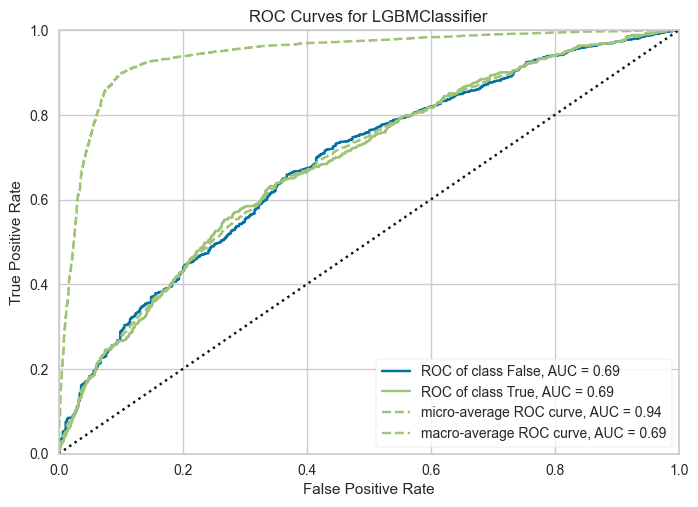

In [32]:
plot_model(tuned_lgbm, plot='auc')   

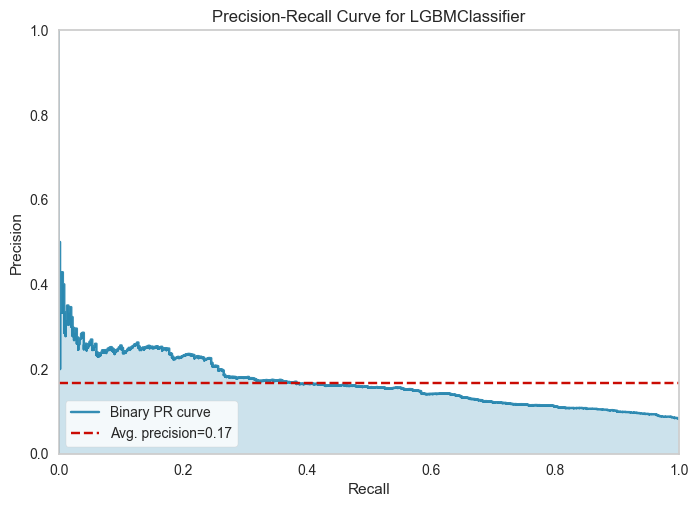

In [33]:
plot_model(tuned_lgbm, plot='pr')  

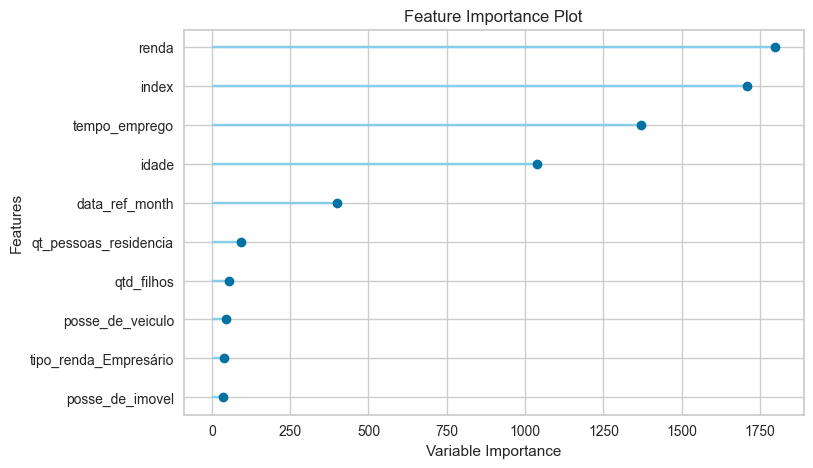

In [34]:
plot_model(tuned_lgbm, plot='feature')  

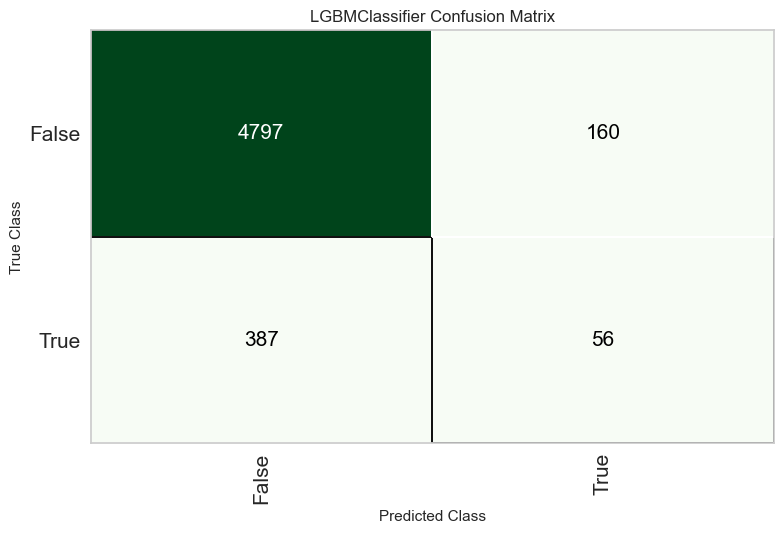

In [35]:
plot_model(tuned_lgbm, plot='confusion_matrix')  

In [36]:
final_lgbm = finalize_model(tuned_lgbm)
predict_model(final_lgbm, data=data_unseen) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9030,0.7063,0.1750,0.3111,0.2240,0.1766,0.1849


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
245481,2015-05-01,8289,F,N,S,0,Assalariado,Superior incompleto,Casado,Casa,41,4.134246,2.0,26876.199219,False,0,0.9976
166088,2015-04-01,15150,F,S,N,2,Assalariado,Superior completo,Casado,Casa,34,8.747945,4.0,18381.980469,False,0,1.0000
18191,2015-01-01,3420,F,N,S,0,Assalariado,Superior completo,Casado,Casa,57,13.194521,2.0,4726.720215,False,0,0.9951
219644,2015-05-01,7983,F,N,S,1,Assalariado,Pós graduação,Solteiro,Casa,34,7.586301,2.0,20387.519531,False,0,0.9956
365761,2015-08-01,1290,F,N,S,0,Pensionista,Superior completo,Casado,Casa,59,NaN,2.0,11792.440430,False,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627789,2016-01-01,11512,F,N,S,2,Assalariado,Médio,Casado,Casa,40,7.183562,4.0,3485.340088,False,0,0.9975
8784,2015-01-01,8154,M,S,S,0,Assalariado,Médio,Casado,Casa,53,8.893150,2.0,9420.830078,False,0,0.9965
548500,2015-11-01,7064,M,S,N,0,Assalariado,Médio,Solteiro,Governamental,33,4.293151,1.0,9776.400391,False,0,0.9762
329220,2015-07-01,14591,F,N,S,1,Assalariado,Médio,Viúvo,Casa,38,8.136987,2.0,50221.859375,False,0,0.9965


### Salvar o arquivo do modelo treinado

In [37]:
save_model(final_lgbm, 'modelo_final_lgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.8,
                                 importance_typ

----------------------------------------------------------------------------------------------------------------------------------------------

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.

----------------------------------------------------------------------------------------------------------------------------------------------